In [35]:
import pickle 
import pennylane as qml
import pennylane.numpy as np
import jax
import jax.numpy as jnp
import optax
import jaxopt


import os, sys, argparse

parent = os.path.abspath('../src')
sys.path.insert(1, parent)

from perceptron import Perceptron

from perceptron import NativePerceptron
import time 

import matplotlib.pyplot as plt


In [36]:
Ntrials=100
N=5
P=5*N


# Configuration settings
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")

# Setting up the quantum perceptron problem
perceptron_qubits = N
n_axis=2
pulse_basis = P
sigma=0.1
save_path = ''
n_epochs = 200

ts = jnp.array([1.0])
t = 1
times = jnp.linspace(0,t, pulse_basis+2)[1:-1]
dev = qml.device("default.qubit.jax", wires=perceptron_qubits)

#Setting up perceptron
perceptron = NativePerceptron(perceptron_qubits, pulse_basis, basis='fourier', pulse_width=sigma, native_coupling=1)
H = perceptron.H

#Setting up target unitary
H_obj, H_obj_spectrum = perceptron.get_1d_ising_hamiltonian(0.1)
W = qml.evolve(H_obj, coeff=1)

hcs = [qml.PauliX(n) for n in range(perceptron_qubits)]
hcs+= [qml.PauliY(n) for n in range(perceptron_qubits)]
# Defining the loss function

@jax.jit
def loss(param_vector):
    param_list = perceptron.vector_to_hamiltonian_parameters(param_vector)
    U = qml.matrix(qml.evolve(perceptron.H)(param_list, t))
    return qml.math.frobenius_inner_product(jnp.conjugate(U-qml.matrix(W)), U-qml.matrix(W)).real


# print('Final loss: ', res.state.value_and_grad)
# print('Max grad: ', np.max(res.state.grad))

/Users/jorgegarciaponce/Research/Yelin/PerceptronLossLandscapes/.venv/lib/python3.11/site-packages/pennylane/ops/functions/eigvals.py:108: UserWarning: For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires. Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.
  warnings.warn(


In [37]:
loss_history = []
parameters_history = []

def callback(params):
    parameters_history.append(params)
    current_loss = loss(params)
    loss_history.append(current_loss)


solver = jaxopt.ScipyMinimize(method='Nelder-Mead', fun=loss, callback=callback)


In [38]:
random_seed = int(time.time() * 1000)  # time in milliseconds
param_vector = perceptron.get_random_parameter_vector(random_seed)

res=solver.run(param_vector)
print(res)

/Users/jorgegarciaponce/Research/Yelin/PerceptronLossLandscapes/.venv/lib/python3.11/site-packages/scipy/optimize/_minimize.py:560: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,


OptStep(params=Array([0.90815588, 0.705076  , 0.79375417, 0.97672751, 0.89131049,
       0.19897614, 0.17158972, 0.79445562, 0.77112614, 0.10582903,
       0.4457765 , 0.42834981, 0.32359638, 0.58765979, 0.10404568,
       0.19253082, 0.65164109, 0.69635074, 0.44805862, 0.08228743,
       0.9610441 , 0.50782019, 0.82562051, 0.17732092, 0.75269856,
       0.00678523, 0.97842708, 0.65388874, 0.42795824, 0.49847879,
       0.78831787, 0.63808673, 0.20709025, 0.16634758, 0.07334163,
       0.63510932, 0.47457242, 0.10554933, 0.73990481, 0.85575838,
       0.17844896, 0.09445475, 0.10922904, 0.12284548, 0.85338218,
       0.08601752, 0.81848402, 0.55538007, 0.23651012, 0.73144943,
       0.11360561, 0.30283098, 0.2126048 , 0.32387287, 0.42172779,
       0.0772903 , 0.28335187, 0.33853402, 0.62587045, 0.34637715,
       0.36223631, 0.92987047, 0.27388468, 0.48684355, 0.69305342,
       0.03608221, 0.8811912 , 0.16078   , 0.45780209, 0.70881856,
       0.14475502, 0.35148716, 0.57531556, 0.98

In [39]:
res.params

Array([0.90815588, 0.705076  , 0.79375417, 0.97672751, 0.89131049,
       0.19897614, 0.17158972, 0.79445562, 0.77112614, 0.10582903,
       0.4457765 , 0.42834981, 0.32359638, 0.58765979, 0.10404568,
       0.19253082, 0.65164109, 0.69635074, 0.44805862, 0.08228743,
       0.9610441 , 0.50782019, 0.82562051, 0.17732092, 0.75269856,
       0.00678523, 0.97842708, 0.65388874, 0.42795824, 0.49847879,
       0.78831787, 0.63808673, 0.20709025, 0.16634758, 0.07334163,
       0.63510932, 0.47457242, 0.10554933, 0.73990481, 0.85575838,
       0.17844896, 0.09445475, 0.10922904, 0.12284548, 0.85338218,
       0.08601752, 0.81848402, 0.55538007, 0.23651012, 0.73144943,
       0.11360561, 0.30283098, 0.2126048 , 0.32387287, 0.42172779,
       0.0772903 , 0.28335187, 0.33853402, 0.62587045, 0.34637715,
       0.36223631, 0.92987047, 0.27388468, 0.48684355, 0.69305342,
       0.03608221, 0.8811912 , 0.16078   , 0.45780209, 0.70881856,
       0.14475502, 0.35148716, 0.57531556, 0.98898332, 0.08522

In [40]:
len(loss_history)
loss_history[-1]

Array(62.99179093, dtype=float64)

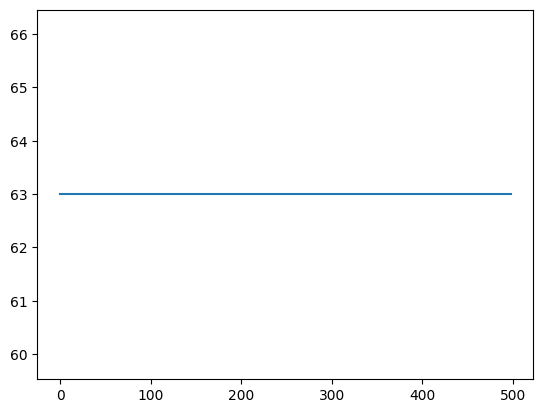

In [41]:
plt.plot(loss_history)